<center>
<img src="../Graphics/logo.png" width="600" />    
</center> 

# 04 - The Hydrogen Atom

This tutorial is part of the [Quantum Chemistry Foundations](https://github.com/fevangelista/Quantum-Chemistry-Foundations) series.

Author: Francesco A. Evangelista

Support: [![NSF-1928366](https://img.shields.io/badge/NSF-2312105-blue.svg)](https://nsf.gov/awardsearch/showAward?AWD_ID=2312105)

---

This tutorial will focus on solving the Schrödinger equation for the hydrogen atom with the variational method. We will derive the Hamiltonian for the hydrogen atom, introduce atomic units, and evaluate one-electron integrals in an atomic orbital basis.
This tutorial will cover the derivation and implementation of all equations, exposing you to some aspects of the process involved in developing more advanced quantum chemistry codes.

This tutorial has an accompanying **[appendix](./04-Hydrogen%20Atom%20Integrals.ipynb)** with all the necessary mathematical derivations of the integrals.

Let's start by importing NumPy, SciPy, and matplotlib. In this tutorial we will use SciPy to evaluate integrals numerically.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## The Hydrogen Atom Hamiltonian 🔍

To begin the tutorial, we will start by recalling the form of the Hamiltonian operator ($\hat{H}$) for the hydrogen atom.
For any quantum system, in the absence of external fields, we can write the Hamiltonian as a sum of the total kinetic energy of all the particles ($\hat{T}$) and a potential term describing their interactions ($\hat{V}$).

In setting up our problem, we will start with the **Born–Oppenheimer approximation**: we will pin the proton at the center of our coordinate system, and we will treat it as a classical point charge that creates an electrostatic potential. With this assumption, then the Hamiltonian includes only the electron.
The Hamiltonian is the sum of the kinetic energy of the electron plus the Coulomb interaction with the electric potential generated by the proton:

\begin{equation}
\hat{H} =  \hat{T} + \hat{V}.
\end{equation}

The kinetic energy of an electron is a generalization of the classical formula $T = \mathbf{p}^2 / 2m_e$, where $\mathbf{p} = (p_x,p_y,p_z)$ is the momentum vector. This vector can be written in terms of the mass of the electron ($m_e$) and its velocity $\mathbf{v}$ as $\mathbf{p} = m_e \mathbf{v}$.
In quantum mechanics, the classical momentum vector is promoted to the **momentum operator**, which has three components like the momentum vector.
This operator is a vector of derivatives times the imaginary unit ($i$) and Planck's constant ($\hbar$):

\begin{equation}
\hat{\mathbf{p}} = -i \hbar \left(\frac{\partial}{\partial x}, \frac{\partial}{\partial y}, \frac{\partial}{\partial z} \right).
\end{equation}

The kinetic energy operator is defined as in the classical case with $\mathbf{p}$ replaced by the momentum operator:

\begin{equation}
\hat{T} = \frac{\hat{\mathbf{p}}^2}{2 m} = \frac{\hat{\mathbf{p}} \cdot \hat{\mathbf{p}}}{2 m}.
\end{equation}

From this expression, we can derive the form of the kinetic energy operator:

\begin{equation}
\begin{split}
\hat{T} = & \frac{\hat{\mathbf{p}} \cdot \hat{\mathbf{p}}}{2 m_e} \\
= & \frac{1}{2 m_e}
\left[
    -i \hbar \left(\frac{\partial}{\partial x}, \frac{\partial}{\partial y}, \frac{\partial}{\partial z} \right)
\right] \cdot
\left[
    -i \hbar \left(\frac{\partial}{\partial x}, \frac{\partial}{\partial y}, \frac{\partial}{\partial z} \right)
\right] \\
= & -\frac{\hbar^2}{2 m_e}
\left(
    \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}
\right) \\
= & -\frac{\hbar^2}{2 m_e} \nabla^2.
\end{split}
\end{equation}

where we used the fact that $i^2 = -1$. We also took the dot product of the two vectors containing derivatives, which gives us the sum of  three second derivatives.
The last equation introduces the symbol $\nabla^2$ (called the Laplacian) to indicate the sum of second derivatives.

The potential energy is just given by Coulomb's law and can be written in SI units as the product of the charge of the electron ($q_e$) and the proton ($q_p = -q_e$) as:
\begin{equation}
\hat{V} = \frac{q_e q_p}{4 \pi \epsilon_0} \frac{1}{r}
= - \frac{q_e^2}{4 \pi \epsilon_0} \frac{1}{r} .
\end{equation}

## The Hamiltonian in Atomic Units 🔍

Now that we have an expression for the components of the Hamiltonian, we can combine them to get our Hamiltonian! However, before we do so, we want to switch to a different set of units that will make our expressions much simpler.

In the **atomic units** system, we scale the units with which we measure lengths, time, masses, charges, etc. so that the constants that enter into the Hamiltonian simplify. Specifically in atomic units, we have that:
- Planck's constant is one:
\begin{equation}
\hbar = 1 .
\end{equation}

- The mass of the electron is one:
\begin{equation}
m_e = 1 .
\end{equation}

- The charge of the electron is minus one:
\begin{equation}
q_e = -1 .
\end{equation}

- Coulomb's constant is one:
\begin{equation}
\frac{1}{4 \pi \epsilon_0} = 1 .
\end{equation}

In these units, the energy is measured in **hartree**. This quantity is indicated with the symbol $E_\mathrm{h}$. One hartree equals 627.509474 kcal mol<sup>-1</sup> or 27.211386 eV.

When we use these units, the Hamiltonian can be written in a very compact form as:

\begin{equation}
\begin{split}
\hat{H} = -\frac{1}{2}
\left(
    \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}
\right)
- \frac{1}{r} .
\end{split}
\end{equation}

Isn't this much nicer?

The **exact eigenvalues** of the hydrogen atom Hamiltonian are known in closed form and can be expressed in atomic units as:
\begin{equation}
E_n = -\frac{1}{2 n^2},
\end{equation}
where $n$ is principal quantum number that takes the integer values $1, 2, 3, \ldots$.

## Approximating the Wave Function using a Linear Combination of Basis Functions
The Schrödinger equation for the hydrogen atom reads:

\begin{equation}
\hat{H} \psi(\mathbf{r}) = E \psi(\mathbf{r}),
\end{equation}

where we have explicitly indicated that the wave function $\psi(\mathbf{r})$ depends on the vector of Cartesian coordinates $\mathbf{r} = (x,y,z)$.

How can we solve this eigenvalue equation? The approach we will follow here is conceptually related to the one we used in Hückel theory: we will approximate $\psi(\mathbf{r})$ by expanding it in a basis of functions.
This means that we will write $\psi(\mathbf{r})$ as a sum of some set of functions $\chi_\mu(\mathbf{r})$ times a set of coefficients:

\begin{equation}
\psi(\mathbf{r}) \approx 
\sum_{\mu = 1}^{K} \chi_\mu(\mathbf{r}) C_{\mu}.
\end{equation}

In this equation, the sum runs from $\mu = 1$ to $K$, where $K$ is the total number of basis functions.
If the basis functions $\chi_\mu(\mathbf{r})$ form a **complete set**, we are then guaranteed that as $K$ goes to infinity, we can reduce the error in this approximation to zero (provided that the wave function is well behaved).

Following the same approach we used in the derivation of Hückel theory (see **[Appendix of Tutorial 02](../02-Hückel%20Theory/02-Hückel%20Theory.ipynb)**), we plug in the definition of the approximate wave function in the Schrödinger equation, left-project on each element of the basis, and finally arrive at the following generalized eigenvalue problem:
\begin{equation}
\mathbf{HC}
= \mathbf{SC} E,
\end{equation}
where $\mathbf{H}$ is the matrix representation of the Hamiltonian operator:
\begin{equation}
H_{\mu \nu} = \langle \chi_\mu |\hat{H}| \chi_\nu \rangle = \int \chi^*_\mu(\mathbf{r}) \hat{H} \chi_\nu(\mathbf{r}) d\mathbf{r},
\end{equation}
while $\mathbf{S}$ is the overlap or metric matrix, with elements defined as:
\begin{equation}
S_{\mu \nu} = \langle \chi_\mu | \chi_\nu \rangle = \int \chi^*_\mu(\mathbf{r}) \chi_\nu(\mathbf{r}) d\mathbf{r}.
\end{equation}

We call the eigenvalue problem above **generalized** because the additional matrix $\mathbf{S}$ appears on the right-hand side in this equation.
In Hückel's theory, we instead get a regular eigenvalue problem because we assume that the 2p<sub>z</sub> orbitals are orthogonal.
In general, a basis set might not be normalized and orthogonal, and we will have to include the matrix $\mathbf{S}$ in our derivation.

## Using Gaussians as Basis Functions

What functions should we choose in our expansion of the wave function? In principle, there are many options (infinitely many), but some families of basis functions are often used in numerical approximations. 

In this tutorial, we will use Gaussian functions centered at the origin whose value depends only on the distance from the origin, $r = \sqrt{x^2 + y^2 + z^2}$.
These functions do not change if we rotate the Cartesian axes in space; therefore, they have the same symmetry as s-type atomic orbitals.
To be precise, this basis is not complete because it cannot be used to describe other orbital types (p, d, etc.). However, it can represent any s-type function with arbitrary accuracy.

A Gaussian basis function is defined as

\begin{equation}
\chi_\mu(\mathbf{r}) = N_{\alpha_\mu} e^{-\alpha_\mu r^2},
\end{equation}

where:
- $\alpha_\mu$ is the exponent of the Gaussian
- $N_{\alpha_\mu}$ is a normalization factor that we introduced to satisfy the condition $\langle \chi_\mu | \chi_\mu \rangle = 1$. The normalization factor is given by:
\begin{equation}
N_{\alpha_\mu} = 
\left(\frac{2\alpha_\mu}{\pi}\right)^{3/4} .
\end{equation}
This equation is derived in the **[appendix](./04-Hydrogen%20Atom%20Integrals.ipynb)** to this tutorial. I would recommend pausing and reviewing the derivation. Or even better, you can try to derive this result on your own to develop your integration skills. 

Let's investigate the properties of this basis. Here we will define a function that evaluates the value of a basis function as a function of the Cartesian coordinates:

In [2]:
def Basis(x,y,z,a):
    """Returns the value of a Gaussian basis function at the point (x,y,z) with exponent a"""
    return (2 * a / np.pi) ** (3/4) * np.exp(-a * (x**2 + y**2 + z**2))

Now we can plot a cross-section of Gaussian functions with different exponents to see what they look like:

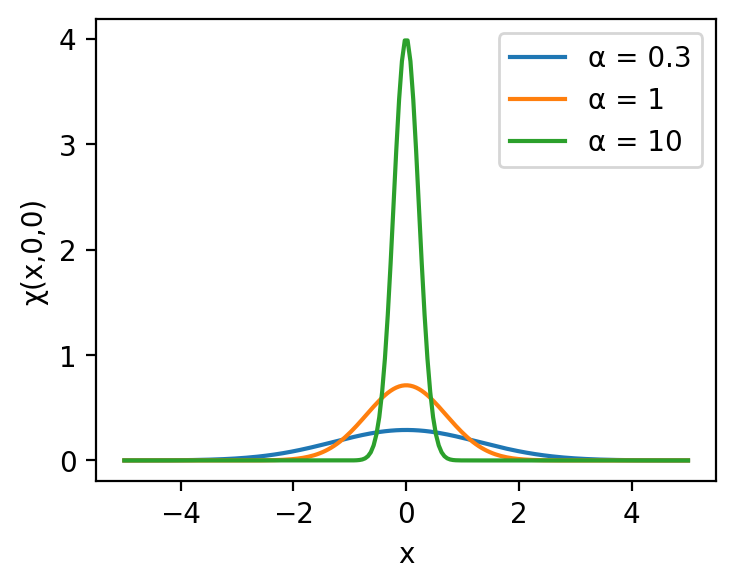

In [3]:
# Create a grid of points along the x-axis
x = np.linspace(-5, 5, 200)

# Plot the basis functions for different values of α
plt.figure(figsize=(4, 3))
for a in [0.3, 1, 10]:
    plt.plot(x, Basis(x,0,0,a), label=f'α = {a}')
    
# Aesthetic adjustments
plt.legend(); plt.xlabel('x'); plt.ylabel('χ(x,0,0)'); plt.show()

Let's verify if one of these functions is normalized. We will use the function `tplquad`, which performs triple integrals, to evaluate the integral of the square of a basis function:
\begin{equation}
\langle \chi_\mu | \chi_\mu \rangle = \int [\chi_\mu(\mathbf{r})]^2 d\mathbf{r}
= \int_{-\infty}^\infty \int_{-\infty}^\infty \int_{-\infty}^\infty [\chi_\mu(x,y,z)]^2 dx \, dy \, dz .
\end{equation}
(Here, we have used the fact that Gaussian functions are real to simplify the modulus squared to the square)

To call `tplquad`, we have to pass as a first argument what is called a **callable object**. This function can be called to get the value of the integrand. One way to do so is to define a new function for the square of a Gaussian basis, for example:
```python
def BasisSquared(x,y,z,a):
    return Basis(x,y,z,a) ** 2
```
and then pass this to `tplquad`:

```python
tplquad(BasisSquared, ...)
```

We will use an equivalent approach based on **lambda functions**. Lambda functions are inline definitions of functions. In our case, we can use the following Python code to generate an equivalent callable object:
```python
lambda x, y, z, a: Basis(x,y,z,a) ** 2
```

The next six arguments are the integration limits of the $x$, $y$, and $z$ variables, which we set to $[-\infty, +\infty]$ for each coordinate.
The last parameter, `args=(0.5,)`, is a tuple of arguments we can pass to our lambda function. This parameter specifies the exponent (the `a` variable) and is appended in the call to the lambda function after the $x$, $y$, and $z$ values:

In [4]:
from scipy.integrate import tplquad

# compute the integral of the square of the basis function
integral, error = tplquad(lambda x, y, z, a: Basis(x,y,z,a) ** 2,
    -np.inf, np.inf,
    -np.inf, np.inf,
    -np.inf, np.inf,
    args=(0.5,))

print(f"The integral is {integral} (integration error = {error})")

The integral is 0.9999999999989272 (integration error = 1.4899187722859793e-08)


This function returns a pair of numbers: an estimated value of the integral and the absolute integration error. The estimated integral is very close to 1, as we expect from a normalized function.

## Computing the Overlap Integral

Let's now move onto coding the overlap integral. In the **[appendix](./04-Hydrogen%20Atom%20Integrals.ipynb)**, you will find the derivation for the overlap matrix elements:
<!-- Our first task will be to determine the form of the normalization condition. So let's get ready to do some integrals! -->

\begin{equation}
\langle \chi_\mu | \chi_\nu \rangle
= (\alpha_\mu \alpha_\nu)^{3/4} \left( \frac{2}{\alpha_\mu + \alpha_\nu}\right)^{3/2}  .
\end{equation}

This equation has a simple implementation:

In [5]:
def overlap_integral(a1,a2):
    """Compute the overlap integral between two Gaussian basis functions."""
    return (a1 * a2) ** (3/4) * (2 / (a1 + a2)) ** (3/2)

Let's verify that this function works as expected. First, we will test that the overlap matrix has diagonal elements equal to 1. Here, we use the `assert` command and the function `np.isclose` to verify that the diagonal elements are equal to one:

In [6]:
assert np.isclose(overlap_integral(1,1),1.0)
assert np.isclose(overlap_integral(3,3),1.0)
assert np.isclose(overlap_integral(0.07,0.07),1.0)

One limitation of our implementation is that it cannot properly handle Gaussians with zero exponent. However, since a zero exponent corresponds to a state in the continuum (an electron not bound to the nucleus), it will not be relevant to our problem.

To test the off-diagonal elements, we can verify that our analytic integrals match the numerical ones. Here we evaluate the integral for the product of two functions with $\alpha_\mu = 3$ and $\alpha_\nu = 2$ using `tplquad`. We extended the lambda to take two exponents (`a` and `b`) that we pass to the `Basis` function:

In [7]:
numerical_integral = tplquad(lambda x, y, z, a, b: Basis(x,y,z,a) * Basis(x,y,z,b),
    -np.inf, np.inf,
    -np.inf, np.inf,
    -np.inf, np.inf,
    args=(2,3,))

# test a matrix element
assert np.isclose(overlap_integral(3,2),0.9698474422447792)
assert np.isclose(overlap_integral(3,2),numerical_integral[0])
print(f"Numerical integral = {numerical_integral[0]}")
print(f"Analytical integral = {overlap_integral(3,2)}")
print(f"Difference = {overlap_integral(3,2) - numerical_integral[0]}")

Numerical integral = 0.9698474422443736
Analytical integral = 0.9698474422447794
Difference = 4.057865155004947e-13


## Kinetic energy integral

Next, we will code up the matrix elements of the kinetic energy operator. These integrals are given by the formula:

\begin{equation}
\langle \chi_\mu | \hat{T} | \chi_\nu \rangle 
= - \frac{1}{2} \langle \chi_\mu | \nabla^2 | \chi_\nu \rangle 
= 6 \sqrt{2}  \frac{ (\alpha_\mu \alpha_\nu)^{7/4}}{(\alpha_\mu + \alpha_\nu)^{5/2}} .
\end{equation}

<!-- \begin{equation}
\begin{split}
\frac{\partial^2}{\partial x^2} \chi_\nu(r)
& = N_{\alpha_\nu} \frac{\partial^2}{\partial x^2} e^{-\alpha_\nu r^2} \\
& =  N_{\alpha_\nu} e^{-\alpha_\nu (y^2 + z^2)} \frac{\partial^2}{\partial x^2} e^{-\alpha_\nu x^2} \\
& =  N_{\alpha_\nu} e^{-\alpha_\nu (y^2 + z^2)} \frac{\partial}{\partial x} e^{-\alpha_\nu x^2} (-2 \alpha_\nu x) \\
& =  N_{\alpha_\nu} e^{-\alpha_\nu (y^2 + z^2)} \left[
    e^{-\alpha_\nu x^2} (-2 \alpha_\nu x)^2 
+  e^{-\alpha_\nu x^2} (-2 \alpha_\nu)\right]  \\
& =  N_{\alpha_\nu} e^{-\alpha_\nu (x^2 + y^2 + z^2)} \left[ 4 \alpha_\nu^2 x^2 
-2 \alpha_\nu \right]  \\
& =  \chi_\nu(r) \left[ 4 \alpha_\nu^2 x^2 
-2 \alpha_\nu \right]
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\nabla^2 \chi_\nu(r)
=  \chi_\nu(r) \left[ 4 \alpha_\nu^2 r^2 
-6 \alpha_\nu \right]
\end{split}
\end{equation} -->

In [8]:
def kinetic_energy_integral(a1,a2):
    """Return the kinetic energy integral."""
    return 6. * np.sqrt(2) * (a1 * a2) ** (7/4) / ((a1 + a2) ** (5/2))

To test this function, we compare to a reference value:

In [9]:
# test a matrix element
assert np.isclose(kinetic_energy_integral(3.,2.),3.491450792081205)

If we did not have a refence value, we could use numerical integration to verify the implementation of the kinetic energy integrals. This is a bit involved for the kinetic energy integrals, so we will do it only in the case of the potential energy integrals.

Let's evaluate the kinetic energy integral for a few combination of exponents

In [10]:
print(f"<χ(α= 1)|T|χ(α= 1)> = {kinetic_energy_integral(1,1)}")
print(f"<χ(α=10)|T|χ(α=10)> = {kinetic_energy_integral(10,10)}")
print(f"<χ(α= 1)|T|χ(α= 2)> = {kinetic_energy_integral(1,2)}")
print(f"<χ(α= 1)|T|χ(α=10)> = {kinetic_energy_integral(1,10)}")

<χ(α= 1)|T|χ(α= 1)> = 1.5
<χ(α=10)|T|χ(α=10)> = 15.000000000000004
<χ(α= 1)|T|χ(α= 2)> = 1.830904127917438
<χ(α= 1)|T|χ(α=10)> = 1.1890073391763212


Note how the kinetic energy integrals are always positive for the diagonal case (when $\alpha_\mu = \alpha_\nu$), consistently with the fact that the kinetic energy is always positive.

## Potential energy integral

The potential energy integrals are given by the following expression:

\begin{equation}
\langle \chi_\mu | \hat{V} | \chi_\nu \rangle = -\langle \chi_\mu | \frac{1}{r} | \chi_\nu \rangle  = -4 \sqrt{\frac{2}{\pi}}  \frac{(\alpha_\mu \alpha_\nu)^{3/4} }{\alpha_\mu + \alpha_\nu} .
\end{equation}

Here is its Python implementation:

In [11]:
def potential_energy_integral(a1,a2):
    """Compute the potential energy (nuclear attraction) integral."""
    return -4. * np.sqrt(2 / np.pi) * (a1 * a2) ** (3/4) / (a1 + a2)

We will compare the analytical integral to one computed numerically to check that this implementation is correct.
To implement the integrand of the potential energy integral:

\begin{equation}
- \chi^*_\mu(\mathbf{r}) \frac{1}{r}  \chi_\nu(\mathbf{r}),
\end{equation}
we can define a new lambda function that takes two exponents (`a` and `b`):
```python
lambda x, y, z, a, b: - Basis(x,y,z,a) * Basis(x,y,z,b) / np.linalg.norm([x,y,z])
```
Since $r$ is equivalent to the 2-norm of the position vector ($\| \mathbf{r} \|_2 = \sqrt{x^2 + y^2 + z^2}$), we evaluate it with the `np.linalg.norm` function which computes the 2-norm of a vector.

In [12]:
numerical_integral = tplquad(lambda x, y, z, a, b: - Basis(x,y,z,a) * Basis(x,y,z,b) / np.linalg.norm([x,y,z]),
    -np.inf, np.inf,
    -np.inf, np.inf,
    -np.inf, np.inf,
    args=(2,3,))

A comparison of the analytical and numerical integrals shows that our implementation is correct:

In [13]:
print(f"Numerical integral = {numerical_integral[0]}")
print(f"Analytical integral = {potential_energy_integral(2,3)}")
print(f"Difference = {potential_energy_integral(2,3) - numerical_integral[0]}")

assert np.isclose(potential_energy_integral(2,3),numerical_integral[0])

Numerical integral = -2.4470536229286513
Analytical integral = -2.4470536229258717
Difference = 2.779554364451542e-12


## The Hamiltonian Matrix

We can finally evaluate the Hamiltonian matrix elements as:
\begin{equation}
\langle \chi_\mu | \hat{H} | \chi_\nu \rangle = \langle \chi_\mu | \hat{T} | \chi_\nu \rangle + \langle \chi_\mu | \hat{V} | \chi_\nu \rangle .
\end{equation}

This function is implemented below.

In [14]:
def hamiltonian(a1,a2):
    """Return the Hamiltonian integral for two functions with exponents a1 and a2."""
    return potential_energy_integral(a1,a2) + kinetic_energy_integral(a1,a2)

## Understanding the Role of the Exponent

Now that we have coded all the matrix elements, we will analyze the behavior of the kinetic energy, potential energy, and total Hamiltonian matrix elements.
To do so, we will consider the simplest approximation to the 1s orbital: a **single Gaussian function**. This means that we approximate the 1s orbital with the following function:
\begin{equation}
\psi(\mathbf{r}) \approx N_\alpha e^{-\alpha r^2}.
\end{equation}

For this approximation, the kinetic, potential, and total energy are a function of a single exponent $\alpha$, for example, the total energy is given by:
\begin{equation}
E = E(\alpha) = |N_\alpha|^2 \int e^{-\alpha r^2} \hat{H} e^{-\alpha r^2} d\mathbf{r}.
\end{equation}
These quantities are plotted below using a single Gaussian with exponent $\alpha$ in the range $[10^{-5},1]$:

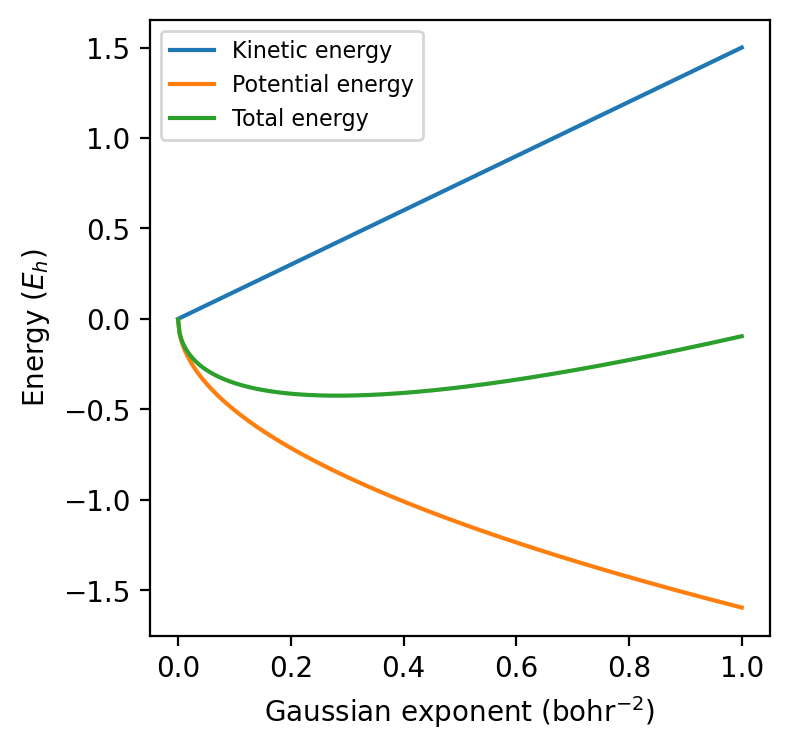

In [15]:
# Create a range of values for the Gaussian exponent
avals = np.linspace(1e-5, 1, 400)

plt.figure(figsize=(4, 4))
plt.plot(avals, kinetic_energy_integral(avals,avals), label='Kinetic energy')
plt.plot(avals, potential_energy_integral(avals,avals), label='Potential energy')
plt.plot(avals, hamiltonian(avals,avals), label='Total energy')

# Adjust spines
plt.xlabel('Gaussian exponent (bohr$^{-2}$)'), plt.ylabel('Energy ($E_h$)')
plt.legend(fontsize=8)
plt.show()

This plot reveals several interesting properties:
- The kinetic energy depends linearly on the Gaussian exponent (you can verify this from the expression).
- The potential energy is negative and becomes more negative as $\alpha$ grows.
- The total energy decreases and then increases.

Let's try to find the value of $\alpha$ that provides the minimum value of the energy. To do so, we can use the SciPy function `scipy.optimize.minimize`. This function requires us to pass a callable function $f(x)$ and an initial guess for the solution $x#. To return the expectation value of the energy of one Gaussian function, we can define the following lambda:

```python
lambda x : hamiltonian(x,x)
```

Calling `scipy.optimize.minimize` will return an object (which we call `res`) that contains information about the optimal value of the parameter (stored in `res.x[0]`) and the value of the minimum energy (stored in `res.fun`):

In [16]:
res = sp.optimize.minimize(lambda x : hamiltonian(x,x), 0.5)

print(f"Minimum energy:  {res.fun}")
print(f"Optimal exponent: {res.x[0]}")

Minimum energy:  -0.42441318157834174
Optimal exponent: 0.2829423068760455


This result is already a good approximation to the energy of the 1s orbital.
It is not particularly accurate since we know from the exact solution of the hydrogen atom that the energy should be exactly -0.5 hartree. To improve upon this result, we will need to consider more than one Gaussian.

## Solving the Schrödinger Equation in a Fixed Gaussian Basis

If the basis set we use to solve the Schrödinger equation is complete, we can systematically add more functions to improve the accuracy of our result. But how should we choose such a basis?

The most compact solution to this problem would result from the optimization of the exponents that define the Gaussian basis functions, as we have done in the case of a single Gaussian. However, this is a nonlinear optimization problem, and consequently, it could be quite challenging due to the presence of local optimal solutions.

A simpler approach, and one that is followed in practice in quantum chemistry codes, is to use a Gaussian basis with **fixed exponents**.
The exponents can be pre-optimized for certain atoms or obtained using a heuristic approach, where they are expressed in terms of a simple formula.
Here, we will follow this second option and use a basis with exponents generated by the so-called **even-tempered** formula:

\begin{equation}
\alpha_\mu = \alpha_0 \beta^{\mu},
\end{equation}

where $\alpha_0$ and $\beta$ are constants and $\mu = 0, 1, \ldots$.
This formula generates the exponents, $\alpha_0$, $\alpha_1 = \alpha_0 \beta$, $\alpha_2 = \alpha_0 \beta^2$, and so on.

The following code, produces an array of exponents for a basis of even-tempered Gaussians:

In [17]:
def even_tempered_basis(K, alpha0, beta):
    return np.array([alpha0 * beta ** i for i in range(K)])

Let's generate the exponents for a small basis with $\alpha_0 = 0.1$ and $\beta = 3$:

In [18]:
exponents = even_tempered_basis(5, 0.1, 3)
exponents

array([0.1, 0.3, 0.9, 2.7, 8.1])

Using this basis, we will form the overlap ($\mathbf{S}$) and Hamiltonian ($\mathbf{H}$) matrices and solve the generalized eigenvalue problem.

The following code implements a function that builds the matrix representation using a given set of exponents. For each list of exponents, we loop over the exponent index ($\mu$) and the corresponding value ($\alpha_\mu$). In this way, we can use the exponent to evaluate the integral and the index to store the computed integral in the appropriate matrix location:

In [19]:
def build_matrices(exponents):
    n = len(exponents)
    H = np.zeros((n,n))
    S = np.zeros((n,n))
    
    for m, a1 in enumerate(exponents): # loop over mu and alpha_mu
        for n, a2 in enumerate(exponents): # loop over nu and alpha_nu
            H[m,n] = hamiltonian(a1,a2)
            S[m,n] = overlap_integral(a1,a2)
            
    return H, S

Using this function we can build the Hamiltonian and overlap matrices and inspect them:

In [20]:
H, S = build_matrices(exponents)

print(f"Hamiltonian matrix:\n{H}")
print(f"\nOverlap matrix:\n{S}")

Hamiltonian matrix:
[[-0.3546265  -0.39381616 -0.39893859 -0.36152598 -0.30183744]
 [-0.39381616 -0.42403874 -0.45218772 -0.53187373 -0.54324222]
 [-0.39893859 -0.45218772 -0.16387951 -0.09344643 -0.4439078 ]
 [-0.36152598 -0.53187373 -0.09344643  1.42788377  1.90744302]
 [-0.30183744 -0.54324222 -0.4439078   1.90744302  7.60836146]]

Overlap matrix:
[[1.         0.80592745 0.464758   0.22611573 0.10284614]
 [0.80592745 1.         0.80592745 0.464758   0.22611573]
 [0.464758   0.80592745 1.         0.80592745 0.464758  ]
 [0.22611573 0.464758   0.80592745 1.         0.80592745]
 [0.10284614 0.22611573 0.464758   0.80592745 1.        ]]


Here, we can see that the overlap matrix has diagonals equal to one (the basis functions are normalized). However, its off-diagonal elements are not zero, which means the basis functions are not orthogonal.

Next, we can solve the generalized eigenvalue problem with the SciPy function `scipy.linalg.eigh`. This function is similar to the NumPy function `numpy.linalg.eigh` but can solve Hermitian generalized eigenvalue problems. `scipy.linalg.eigh` takes as arguments the matrix we want to diagonalize and the metric matrix. It returns the list of eigenvalues and a matrix with the eigenvectors (stored as columns).

In [21]:
E, C = sp.linalg.eigh(H,S)

Let's print the eigenvalues:

In [22]:
E

array([-4.99110660e-01,  6.19582913e-03,  1.17526649e+00,  5.43735044e+00,
        1.99778830e+01])

We see that the lowest eigenvalue (-0.499110660 $E_\mathrm{h}$) corresponds to a bound state (since its energy is negative).
This result agrees well with the exact energy of the 1s orbital (-0.5 $E_\mathrm{h}$).

In principle, we should be able to obtain approximations to s-type excited states (2s, 3s, ...). However, we find that the remaining four states are not bound. To obtain more bound states, we need to use a different or larger basis.

## Visualizing the Optimized Orbitals

Let's visualize the 1s orbital we just found. We can express the wavefunction at an arbitrary point $\mathbf{r}$ in space using the Gaussian basis:

\begin{equation}
\psi(\mathbf{r}) \approx 
\sum_{\mu = 1}^{K} \chi_\mu(\mathbf{r}) C_{\mu}.
\end{equation}
Where the expansion coefficients for the lowest energy state are contained in the first column of the `C` matrix.

In our case we can easily print these coefficients in this way using slicing of NumPy arrays:

In [23]:
C[:,0] # a slice containing all rows of the column indexed by 0

array([0.36621835, 0.47286696, 0.22134213, 0.05284114, 0.02715026])

We can easily write a function to evaluate the wavefunction by summing up the product of the orbital coefficient matrix times the basis function:

In [24]:
def Psi(x,y,z,exponents,c):
    """Return the value of an orbital expanded in a Gaussian basis at a given point in space."""
    return sum(c_a * Basis(x,y,z,a) for a, c_a in zip(exponents,c))

Next we can make a fancy plot that will show the 1s orbital and the cumulative contribution of the Gaussian basis functions, starting with the Gaussian with the largest value of $\alpha$.

Here we first adjust the phase of the orbital so that it is positive for the first function:
```python
c= -C[:,0] if C[0,0] < 0.0 else C[:,0]
```
We are allowed to do this because the properties of a wavefunction are independent of its overall phase.

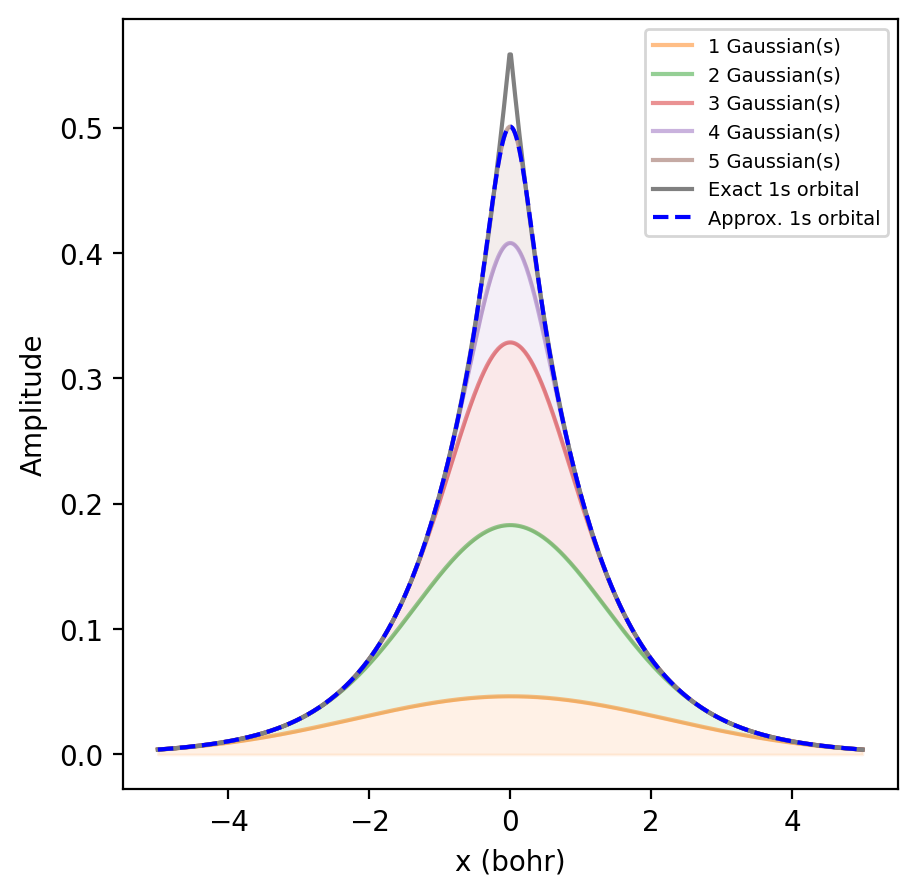

In [25]:
# Create a grid of points along the x-axis
r = np.linspace(-5, 5, 500)

# Fix the sign of the coefficients
c= -C[:,0] if C[0,0] < 0.0 else C[:,0]

plt.figure(figsize=(5, 5))

# Plot the sum of the first K Gaussians contributing to the wavefunction
for i in range(1,6):
    plt.plot(r, Psi(r,0,0,exponents[:i],c[:i]),label=f'{i} Gaussian(s)',color=f'C{i}',alpha=0.5)
    plt.fill_between(r, Psi(r,0,0,exponents[:i],c[:i]),Psi(r,0,0,exponents[:i-1],c[:i-1]), alpha=0.1, color=f'C{i}')

# Plot the wavefunction
plt.plot(r, np.exp(-np.abs(r)) / np.sqrt(np.pi),label='Exact 1s orbital',color='gray',linestyle='-')
plt.plot(r, Psi(r,0,0,exponents,c),label='Approx. 1s orbital',color='blue',linestyle='--')


plt.xlabel('x (bohr)'), plt.ylabel('Amplitude'), plt.legend(fontsize=7)
plt.show()

The plot above nicely shows how the basis functions contribute to the main features of the 1s orbital: a cusp-like behavior near the origin ($x=0$) and an exponential decay as $x$ increases. This plot also shows the exact solution to the hydrogen atom (in atomic units):
\begin{equation}
\psi_\mathrm{1s}(\mathbf{r}) = \frac{1}{\sqrt{\pi}} e^{-r},
\end{equation}
which has an actual cusp at the origin. The first derivative of this wave function is discontinuous at the origin.

A Gaussian basis cannot capture the cusp exactly at $r = 0$ because each basis function has a continuous derivative at the origin. However, the cusp can be approximated more accurately as we saturate the basis set.

## Converging to the basis set limit

In this last section we will try to push our numerical solutions to find accurate energies for the first five s levels of the hydrogen atom.

Let's start be writing a convenience function that computes the eigenvalues for a given set of coefficients:

In [26]:
def compute_eigenvalues(exponents):
    """Compute the eigenvalues of the Hamiltonian for a given set of Gaussian exponents."""
    H, S = build_matrices(exponents)
    E, C = sp.linalg.eigh(H,S)
    return E

Let's compute the energies (and errors) of the first five states using the parameters $\alpha_0 = 0.001$ and $\beta = 2$:

In [27]:
energies = compute_eigenvalues(even_tempered_basis(10, 1e-3, 2))

for i, E in enumerate(energies[:5]):
    n = i + 1 # principal quantum number
    error = E + 0.5 / (n)**2
    print(f"Energy level {n}: {E:.6f} Eh (error = {error:.6f} Eh)")

Energy level 1: -0.471206 Eh (error = 0.028794 Eh)
Energy level 2: -0.121206 Eh (error = 0.003794 Eh)
Energy level 3: -0.054418 Eh (error = 0.001138 Eh)
Energy level 4: -0.030767 Eh (error = 0.000483 Eh)
Energy level 5: -0.019743 Eh (error = 0.000257 Eh)


Now all the states are bound and the energies agree well with those of the 1s–5s orbitals. Let's try to decrease the errors by using a larger basis with 20 functions:

In [28]:
energies = compute_eigenvalues(even_tempered_basis(20, 1e-3, 2))

for i, E in enumerate(energies[:5]):
    n = i + 1
    error = E + 0.5 / (n)**2
    print(f"Energy level {n}: {E:.6f} Eh (error = {error:.6f} Eh)")

Energy level 1: -0.499998 Eh (error = 0.000002 Eh)
Energy level 2: -0.125000 Eh (error = 0.000000 Eh)
Energy level 3: -0.055555 Eh (error = 0.000000 Eh)
Energy level 4: -0.031247 Eh (error = 0.000003 Eh)
Energy level 5: -0.019985 Eh (error = 0.000015 Eh)


This larger basis yields more accurate energies for the 1s–5s orbitals, with errors less or equal to 0.000015 Eh (ca. 0.0004 eV).

## The End 🎊

Congratulations! You have now solved the Schrödinger equation for a real system starting from the quantum mechanical Hamiltonian. With this approach you can solve any problem involving one electron. The real trouble begins when we want to find solutions for two or more electrons. This will be the topic of the next tutorial.